In [1]:
import random
import math
import matplotlib.pyplot as plt
import time

In [2]:
FPE = 0.0000000001 # term for correction of floating point errors

# Algorithms

In [3]:
def greedy_max_k(S,k,n):
  scores = {}
  for s in S:
    scores[s] = len(s)
  I = set()
  ans = set()
  while len(I) < k:
    best = 0
    pick = None
    for s in S:
      score = scores[s]
      if score > best:
        best = score
        pick = s
    if pick == None:
      break;
    I.add(frozenset(pick))
    newelem = pick - (ans & pick)
    for s in S:
      scores[s] -= len(newelem & s)
    ans = ans | pick
  return I,ans


def get_da(a, T, S, SZ, SB, ZU):
  # find tight sets
  T.clear()
  for Si in S:
    if SB[Si] >= a-FPE: # correct for floating point errors
      T.add(Si)
  da = 1
  if ZU <= 0:
    da = 0
  # find slowest decreasing tight set
  L = frozenset()
  for Si in T:
    dSi = 0
    if ZU != 0:
      dSi = SZ[Si]/ZU
    if dSi <= da+FPE: # correct for floating point errors
      da = dSi
      L = Si
  return da,L

# returns time and set responsible for the next event
def get_next_event(S,L,alg,a,SB,SZ,ZU):
  if SZ[L] <= 0:
    return 0,L
  if ZU == 0:
    return 0,L
  dt = ZU
  E = L
  # find next "tight" event
  for Si in S:
    if SZ[Si] >= SZ[L]-FPE: # correct for floating point errors
      continue
    tSi = ((SB[L]-SB[Si])*ZU)/(SZ[L]-SZ[Si])
    if tSi < dt:
      E = Si
      dt = tSi
  return dt, E

def dual_max_k(S,k,n):
  # initialize variables
  b = [1] * n
  g = [0] * n
  db = [0] * n
  da = 0
  alg = set()
  I = []
  a = 0
  T = set()
  L = set()
  dt = 0
  # find tight sets and initial alpha
  for Si in S:
    if len(Si) > a:
      a = len(Si)
      T = set([Si])
    elif len(Si) == a:
      T.add(Si)
  SB = {}
  SZ = {}
  ZU = 0
  for Si in S:
    SB[Si] = len(Si)
    SZ[Si] = 0

  while len(I) < k:
    while da > (1/k): # can make dual progress
      dt,E = get_next_event(S,L,alg,a,SB,SZ,ZU)
      # take time step
      for Si in S:
        dSi = (SZ[Si] / ZU)*dt
        SB[Si] -= dSi
        SZ[Si] -= dSi
      ZU -= dt
      a -= da*dt
      # update alpha, tight sets, da, and limiting set
      da,L = get_da(a, T, S, SZ, SB, ZU)
    # can't make progress, pick our blocker
    pick = None
    da,pick = get_da(a, T, S, SZ, SB, ZU)
    # pick and update
    I.append(pick)
    newelem = pick - (alg & pick)
    alg = alg | pick
    ZU += SB[pick] - SZ[pick]
    for Si in S:
      SZ[Si] += len(Si & newelem)
    da,L = get_da(a, T, S, SZ, SB, ZU)
  return set(I),alg, I, (a*k + len(alg)-ZU)
        
      


# Tests

In [4]:
# generates N test cases with n between min_n and max_n
def max_k_coverage_generate_tests(min_n = 100, max_n = 1000, N = 10):
  tests = []
  for i in range(N):
    n = random.randint(min_n, max_n)
    test = max_k_coverage_generate_test(n)
    tests.append(test)
  return tests

# generates a test case for the given n, k, m (or m between m_min and m_max)
def max_k_coverage_generate_test(n, k = None, m = None, min_m = None, max_m = None):
  if k == None:
    k = random.randint(2, n-1)
  if m == None:
    if min_m == None:
      min_m = k+1
    if max_m == None:
      max_m = k*n
    m = random.randint(min_m, max_m)

  # generate sets
  S = []
  for i in range(m):
    S_i = []
    for u in range(n):
      if random.randint(0,1) == 1:
        S_i.append(u)
      if len(S_i) > n/3:
        break
    if S_i != [] and S_i != list(range(n)):
      S.append(frozenset(S_i))
  return n, set(S), k

def random_planar_gen(n, k = None, m = None, min_m = None, max_m = None):
  if m == None:
    if min_m == None:
      min_m = 5
    if max_m == None:
      max_m = max(int(n/4), min_m+1)
    m = random.randint(min_m, max_m)
  if k == None:
    k = random.randint(2, 20)
  
  # uniform at random lay out elements on plane
  elements = {}
  for i in range(n):
    x = random.random()
    y = random.random()
    elements[i] = (x,y)
  
  # uniform at random lay out set centers and define radii
  S = set()
  sets = {}
  for i in range(m):
    Si = []
    x = random.random()
    y = random.random()
    r = random.uniform(0.0001, 0.15)
    for e in range(n):
      (xe, ye) = elements[e]
      if (xe-x)**2 + (ye-y)**2 <= r**2:
        Si.append(e)
    S.add(frozenset(Si))
    sets[frozenset(Si)] = (x,y,r)
  return n, S, k, elements, sets

def random_grid_gen(n, k = None, m = None, min_m = None, max_m = None):
  if m == None:
    if min_m == None:
      min_m = 5
    if max_m == None:
      max_m = max(int(n/4), min_m+1)
    m = random.randint(min_m, max_m)
  if k == None:
    k = random.randint(2, 20)
  
  # uniform at random lay out elements on grid
  elements = {}
  for i in range(n):
    x = random.random()
    y = random.random()
    closex = round(x,1)
    closey = round(y,1)
    if abs(x-closex) <= abs(y-closey):
      x = closex
    else:
      y = closey
    elements[i] = (x,y)

  # uniform at random select grid crossings to be set centers and choose radii
  S = set()
  sets = {}
  for i in range(m):
    Si = []
    x = random.randint(0,10) / 10
    y = random.randint(0,10) / 10
    r = random.uniform(0.0001, 0.2)
    r = 0.1
    for e in range(n):
      (xe, ye) = elements[e]
      if (xe-x)**2 + (ye-y)**2 <= r**2:
        Si.append(e)
    S.add(frozenset(Si))
    sets[frozenset(Si)] = (x,y,r)
  return n, S, k, elements, sets

def random_weighted_grid_gen(n, k = None, m = None, min_m = None, max_m = None):
  if m == None:
    if min_m == None:
      min_m = 5
    if max_m == None:
      max_m = max(int(n/3), min_m+1)
    m = random.randint(min_m, max_m)
  if k == None:
    # k = random.randint(2, max(3,int(m/3)))
    k = random.randint(2, 20)

  # select element locations from weighted grid distribution
  elements = {}
  for i in range(n):
    x = (((2*(random.random()-0.5))**3)+1)/2
    y = (((2*(random.random()-0.5))**3)+1)/2
    closex = round(x,1)
    closey = round(y,1)
    if abs(x-closex) <= abs(y-closey):
      x = closex
    else:
      y = closey
    elements[i] = (x,y)
  
  # uniform at random select grid crossings to be set centers and choose radii
  S = set()
  sets = {}
  for i in range(m):
    Si = []
    x = random.randint(0,10) / 10
    y = random.randint(0,10) / 10
    r = random.uniform(0.0001, 0.15)
    r = 0.1
    for e in range(n):
      (xe, ye) = elements[e]
      if (xe-x)**2 + (ye-y)**2 <= r**2:
        Si.append(e)
    S.add(frozenset(Si))
    sets[frozenset(Si)] = (x,y,r)
  return n, S, k, elements, sets

def gen_greedy_tight(n,k):
  size = math.floor(n/k)
  opt = size * k
  print(size)
  S = set()
  # generate optimal sets
  for i in range(k):
    si = [j for j in range(size*i, size*i+size)]
    S.add(frozenset(si))
  # generate 'decoy' sets
  size_decoy = size
  offset = 0
  for i in range(k):
    sd = set()
    sps = math.floor(size_decoy/k) + 1
    for i in range(k):
      start = size*i+offset
      end = start + sps
      for i in range(start, end):
        if(i < n):
          sd.add(i)
    S.add(frozenset(sd))
    offset += sps
    size_decoy -= sps
  return n,S,k,opt

print(gen_greedy_tight(16,4))
# random_street_grid()

4
(16, {frozenset({11, 3, 15, 7}), frozenset({2, 10, 6, 14}), frozenset({0, 1, 4, 5, 8, 9, 12, 13}), frozenset({8, 9, 10, 11}), frozenset({12, 13, 14, 15}), frozenset({0, 1, 2, 3}), frozenset({8, 4, 12}), frozenset({4, 5, 6, 7})}, 4, 16)


# Random Planar Set Generation Trials

In [5]:
# plot a visualization of the universe, sets, and sets chosen in a specific trial
def visualize_trial(n,S,elem,sets,Ag,Ad):
  for i in range(n):
    found = False
    for Si in S:
      if i in Si:
        found = True
    if not found:
      continue
    x,y = elem[i]
    color = 'black'
    if i in Ag and i in Ad:
      color = 'purple'
    elif i in Ag:
      color = 'red'
    elif i in Ad:
      color = 'blue'
    plt.plot(x, y, 'o', color=color)
  for Si in S:
    x,y,r = sets[Si]
    circle = None
    if Si in Id and Si in Ig:
      circle = plt.Circle((x, y), r, color='purple', fill=False)
    elif Si in Id:
      circle = plt.Circle((x, y), r, color='blue', fill=False)
    elif Si in Ig:
      circle = plt.Circle((x, y), r, color='red', fill=False)
    else:
      circle = plt.Circle((x, y), r, color='green', fill=False)
    plt.gca().add_patch(circle)
  plt.show()

average pd-greedy ratio: 0.9719680005116984
average pd-dual ratio: 0.8984024991315228
min greedy-pd ratio: 0.8125
min pd-dual ratio: 0.7648864430314646


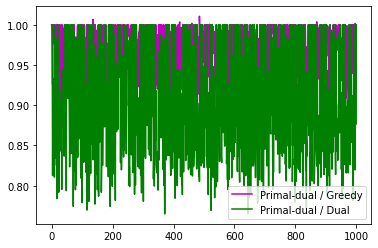

average pd-greedy time ratio: 1.936500577978695


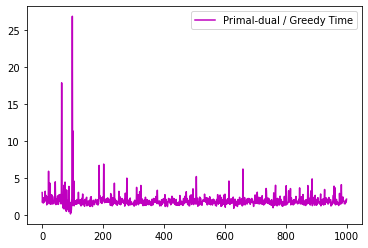

In [6]:
TRIALS = 1000
Xs = [i for i in range(TRIALS)]
ratioGD = [0] * TRIALS
ratioDD = [0] * TRIALS
timeGD = [0] * TRIALS

for i in range(TRIALS):
  n = random.randint(200, 2000)
  n,S,k,elem,sets = random_planar_gen(n)
  tsg = time.time()
  Ig,Ag = greedy_max_k(S,k,n)
  tsd = time.time()
  Id,Ad,Idts, dual = dual_max_k(S,k,n)
  tfd = time.time()
  timeGD[i] = (tfd-tsd)/(tsd-tsg)
  # print(len(Ad), len(Ag))
  if dual == 0:
    ratioDD[i] = 1
  else:
    ratioDD[i] = len(Ad) / dual
  if len(Ag) == 0:
    ratioGD[i] = 1
  else:
    ratioGD[i] = len(Ad) / len(Ag)
  # visualize_trial(n,S,elem,sets,Ag,Ad)

plt.plot(Xs, ratioGD, color = 'm', label = 'Primal-dual / Greedy')
plt.plot(Xs, ratioDD, color = 'g', label = 'Primal-dual / Dual')
print("average pd-greedy ratio:", sum(ratioGD)/TRIALS)
print("average pd-dual ratio:", sum(ratioDD)/TRIALS)
print("min greedy-pd ratio:", min(ratioGD))
print("min pd-dual ratio:", min(ratioDD))
plt.legend()
plt.show()
print("average pd-greedy time ratio:", sum(timeGD)/TRIALS)
plt.plot(Xs, timeGD, color = 'm', label = 'Primal-dual / Greedy Time')
plt.legend()
plt.show()

# Random Grid Set Generation Trials

average pd-greedy ratio: 0.9679776542366588
average pd-dual ratio: 0.9479926910304338
min greedy-pd ratio: 0.8159203980099502
min pd-dual ratio: 0.7543261498874237


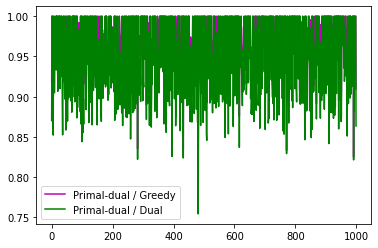

average pd-greedy time ratio: 1.8655172671873306


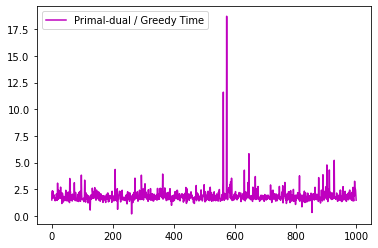

In [7]:
TRIALS = 1000
Xs = [i for i in range(TRIALS)]
ratioGD = [0] * TRIALS
ratioDD = [0] * TRIALS
timeGD = [0] * TRIALS

for i in range(TRIALS):
  n = random.randint(200, 2000)
  n,S,k,elem,sets = random_grid_gen(n)
  tsg = time.time()
  Ig,Ag = greedy_max_k(S,k,n)
  tsd = time.time()
  Id,Ad,Idts, dual = dual_max_k(S,k,n)
  tfd = time.time()
  timeGD[i] = (tfd-tsd)/(tsd-tsg)
  # print(len(Ad), len(Ag))
  if dual == 0:
    ratioDD[i] = 1
  else:
    ratioDD[i] = len(Ad) / dual
  if len(Ag) == 0:
    ratioGD[i] = 1
  else:
    ratioGD[i] = len(Ad) / len(Ag)
  # visualize_trial(n,S,elem,sets,Ag,Ad)

plt.plot(Xs, ratioGD, color = 'm', label = 'Primal-dual / Greedy')
plt.plot(Xs, ratioDD, color = 'g', label = 'Primal-dual / Dual')
print("average pd-greedy ratio:", sum(ratioGD)/TRIALS)
print("average pd-dual ratio:", sum(ratioDD)/TRIALS)
print("min greedy-pd ratio:", min(ratioGD))
print("min pd-dual ratio:", min(ratioDD))
plt.legend()
plt.show()
print("average pd-greedy time ratio:", sum(timeGD)/TRIALS)
plt.plot(Xs, timeGD, color = 'm', label = 'Primal-dual / Greedy Time')
plt.legend()
plt.show()

# Random Center Dense Grid Set Gen Trials

average pd-greedy ratio: 0.9845378185814407
average pd-dual ratio: 0.9257110604284753
min greedy-pd ratio: 0.8963675213675214
min pd-dual ratio: 0.8144509804854646


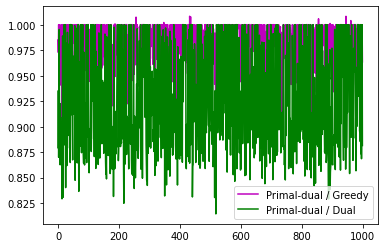

average pd-greedy time ratio: 2.078297215694925


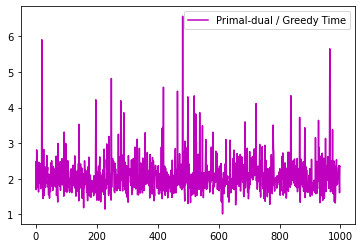

In [8]:
TRIALS = 1000
Xs = [i for i in range(TRIALS)]
ratioGD = [0] * TRIALS
ratioDD = [0] * TRIALS
timeGD = [0] * TRIALS

for i in range(TRIALS):
  n = random.randint(200, 2000)
  n,S,k,elem,sets = random_weighted_grid_gen(n)
  tsg = time.time()
  Ig,Ag = greedy_max_k(S,k,n)
  tsd = time.time()
  Id,Ad,Idts, dual = dual_max_k(S,k,n)
  tfd = time.time()
  timeGD[i] = (tfd-tsd)/(tsd-tsg)
  # print(len(Ad), len(Ag))
  if dual == 0:
    ratioDD[i] = 1
  else:
    ratioDD[i] = len(Ad) / dual
  if len(Ag) == 0:
    ratioGD[i] = 1
  else:
    ratioGD[i] = len(Ad) / len(Ag)
  # visualize_trial(n,S,elem,sets,Ag,Ad)

plt.plot(Xs, ratioGD, color = 'm', label = 'Primal-dual / Greedy')
plt.plot(Xs, ratioDD, color = 'g', label = 'Primal-dual / Dual')
print("average pd-greedy ratio:", sum(ratioGD)/TRIALS)
print("average pd-dual ratio:", sum(ratioDD)/TRIALS)
print("min greedy-pd ratio:", min(ratioGD))
print("min pd-dual ratio:", min(ratioDD))
plt.legend()
plt.show()
print("average pd-greedy time ratio:", sum(timeGD)/TRIALS)
plt.plot(Xs, timeGD, color = 'm', label = 'Primal-dual / Greedy Time')
plt.legend()
plt.show()

## Random Planar Set Gen (N=4000)

average pd-greedy ratio: 0.96622133635999
average pd-dual ratio: 0.8724297270076031
min greedy-pd ratio: 0.9291212315586914
min pd-dual ratio: 0.7688188837403718


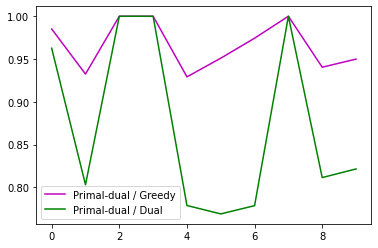

average pd-greedy time ratio: 1.2512849046838368


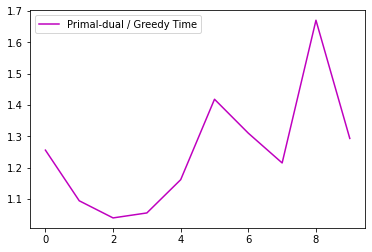

In [9]:
TRIALS = 10
Xs = [i for i in range(TRIALS)]
ratioGD = [0] * TRIALS
ratioDD = [0] * TRIALS
timeGD = [0] * TRIALS
Ns = [0] * TRIALS

for i in range(TRIALS):
  n = 4000
  # k = random.randint(5, n)
  n,S,k,elem,sets = random_planar_gen(n)
  tsg = time.time()
  Ig,Ag = greedy_max_k(S,k,n)
  tsd = time.time()
  Id,Ad,Idts, dual = dual_max_k(S,k,n)
  tfd = time.time()
  timeGD[i] = (tfd-tsd)/(tsd-tsg)
  # print(len(Ad), len(Ag))
  if dual == 0:
    ratioDD[i] = 1
  else:
    ratioDD[i] = len(Ad) / dual
  if len(Ag) == 0:
    ratioGD[i] = 1
  else:
    ratioGD[i] = len(Ad) / len(Ag)

plt.plot(Xs, ratioGD, color = 'm', label = 'Primal-dual / Greedy')
plt.plot(Xs, ratioDD, color = 'g', label = 'Primal-dual / Dual')
print("average pd-greedy ratio:", sum(ratioGD)/TRIALS)
print("average pd-dual ratio:", sum(ratioDD)/TRIALS)
print("min greedy-pd ratio:", min(ratioGD))
print("min pd-dual ratio:", min(ratioDD))
plt.legend()
plt.show()
print("average pd-greedy time ratio:", sum(timeGD)/TRIALS)
plt.plot(Xs, timeGD, color = 'm', label = 'Primal-dual / Greedy Time')
plt.legend()
plt.show()

## Random Planar Set Gen (N=10000)



average pd-greedy ratio: 0.9271401924217691
average pd-dual ratio: 0.836703910493716
min greedy-pd ratio: 0.8536348164356917
min pd-dual ratio: 0.7604834981244629


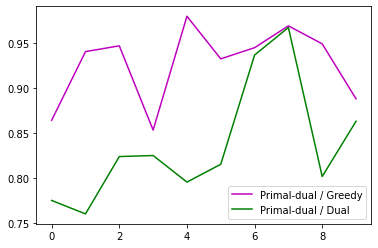

average pd-greedy time ratio: 1.0379316418817157


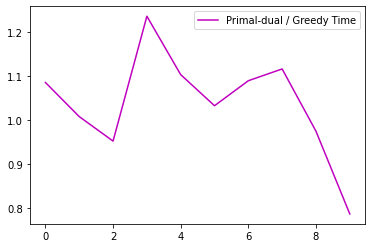

In [10]:
TRIALS = 10
Xs = [i for i in range(TRIALS)]
ratioGD = [0] * TRIALS
ratioDD = [0] * TRIALS
timeGD = [0] * TRIALS
Ns = [0] * TRIALS

for i in range(TRIALS):
  n = 10000
  n,S,k,elem,sets = random_planar_gen(n, min_m=1000, max_m=2000)
  tsg = time.time()
  Ig,Ag = greedy_max_k(S,k,n)
  tsd = time.time()
  Id,Ad,Idts, dual = dual_max_k(S,k,n)
  tfd = time.time()
  timeGD[i] = (tfd-tsd)/(tsd-tsg)
  # print(len(Ad), len(Ag))
  if dual == 0:
    ratioDD[i] = 1
  else:
    ratioDD[i] = len(Ad) / dual
  if len(Ag) == 0:
    ratioGD[i] = 1
  else:
    ratioGD[i] = len(Ad) / len(Ag)

plt.plot(Xs, ratioGD, color = 'm', label = 'Primal-dual / Greedy')
plt.plot(Xs, ratioDD, color = 'g', label = 'Primal-dual / Dual')
print("average pd-greedy ratio:", sum(ratioGD)/TRIALS)
print("average pd-dual ratio:", sum(ratioDD)/TRIALS)
print("min greedy-pd ratio:", min(ratioGD))
print("min pd-dual ratio:", min(ratioDD))
plt.legend()
plt.show()
print("average pd-greedy time ratio:", sum(timeGD)/TRIALS)
plt.plot(Xs, timeGD, color = 'm', label = 'Primal-dual / Greedy Time')
plt.legend()
plt.show()

## Random Planar Set Gen Trials - Hobert Inspired

average pd-greedy ratio: 0.9728395679343482
average pd-dual ratio: 0.8864642174999003
min greedy-pd ratio: 0.8333333333333334
min pd-dual ratio: 0.752366716492277


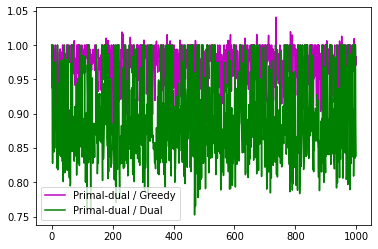

average pd-greedy time ratio: 2.5332448745266323


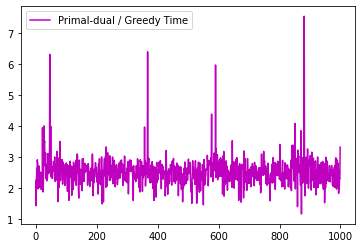

In [11]:
TRIALS = 1000
Xs = [i for i in range(TRIALS)]
Ns = [100, 150, 200]
ratioGD = [0] * TRIALS
ratioDD = [0] * TRIALS
timeGD = [0] * TRIALS

for i in range(TRIALS):
  for n in Ns:
    n,S,k,elem,sets = random_planar_gen(n, min_m=0.5*n, max_m=0.8*n)
    tsg = time.time()
    Ig,Ag = greedy_max_k(S,k,n)
    tsd = time.time()
    Id,Ad,Idts, dual = dual_max_k(S,k,n)
    tfd = time.time()
    timeGD[i] = (tfd-tsd)/(tsd-tsg)
    # print(len(Ad), len(Ag))
    if dual == 0:
      ratioDD[i] = 1
    else:
      ratioDD[i] = len(Ad) / dual
    if len(Ag) == 0:
      ratioGD[i] = 1
    else:
      ratioGD[i] = len(Ad) / len(Ag)
    
    # visualize_trial(n,S,elem,sets,Ag,Ad)

plt.plot(Xs, ratioGD, color = 'm', label = 'Primal-dual / Greedy')
plt.plot(Xs, ratioDD, color = 'g', label = 'Primal-dual / Dual')
print("average pd-greedy ratio:", sum(ratioGD)/TRIALS)
print("average pd-dual ratio:", sum(ratioDD)/TRIALS)
print("min greedy-pd ratio:", min(ratioGD))
print("min pd-dual ratio:", min(ratioDD))
plt.legend()
plt.show()
print("average pd-greedy time ratio:", sum(timeGD)/TRIALS)
plt.plot(Xs, timeGD, color = 'm', label = 'Primal-dual / Greedy Time')
plt.legend()
plt.show()